### **Pytorch 예제** 

https://tutorials.pytorch.kr/beginner/torchtext_translation.html

In [ ]:
!pip install torchtext

In [ ]:
!python -m spacy download en
!python -m spacy download de

     |████████████████████████████████| 12.0 MB 8.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.9 MB 7.4 MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-py3-none-any.whl size=14907055 sha256=287d49145a4a0a05125d59f5d3af45d4161e04b829753c159ac4b2e82b25be3e
  Stored in directory: /tmp/pip-ephem-wheel-cache-bzy1fx92/wheels/00/66/69/cb6c921610087d2cab339062345098e30a5ceb665360e7b32a
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.loa

In [ ]:
import spacy
spacy_en = spacy.load('en')
spacy_de = spacy.load('de')

In [ ]:
tokenized = spacy_en.tokenizer('I am a graduate student')

for i, token in enumerate(tokenized):
  print(f"인덱스 {i}: {token.text}")

인덱스 0: I
인덱스 1: am
인덱스 2: a
인덱스 3: graduate
인덱스 4: student


In [ ]:
# 독일어의경우 문자열을 거꾸로 처리한다. 이는 아마 입력 단어의 순서를 거꾸로 하면 성능이 높아진다는 논문에 기반을 둔 듯 하다.
def tokenize_de(text):
  return [token.text for token in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
  return [token.text for token in spacy_en.tokenizer(text)]

In [ ]:
# SRC - 입력문장 (독일어) / TRG - 번역문장 (영어)
# Field 함수의 경우 자연어처리에서 tokenize, vocab, dataloader 등의 일을 쉽게 처리하기 위해 고안된 함수
# 참고 : https://medium.com/@serotoninpm/pytorch-torchtext-field-bucketiterator-728ae511f133
from torchtext.legacy.data import Field, BucketIterator

SRC = Field(tokenize_de, init_token = "<sos>", eos_token = "<eos>", lower = True)
TRG = Field(tokenize_en, init_token = "<sos>", eos_token = "<eos>", lower = True)

In [ ]:
# Multi30k는 영어-독일어 번역 데이터셋입니다. 
from torchtext.legacy.datasets import Multi30k

train_dataset,valid_dataset,test_dataset = Multi30k.splits(exts=(".de",".en"),fields=(SRC,TRG))

print(f"학습 데이터셋 (training dataset) 크기 : {len(train_dataset.examples)}개")
print(f"학습 데이터셋 (validation dataset) 크기 : {len(valid_dataset.examples)}개")
print(f"학습 데이터셋 (testing dataset) 크기 : {len(test_dataset.examples)}개")

downloading training.tar.gz


100%|██████████| 1.21M/1.21M [00:01<00:00, 616kB/s] 


downloading validation.tar.gz


100%|██████████| 46.3k/46.3k [00:00<00:00, 176kB/s]


downloading mmt_task1_test2016.tar.gz


100%|██████████| 66.2k/66.2k [00:00<00:00, 167kB/s]


학습 데이터셋 (training dataset) 크기 : 29000개
학습 데이터셋 (validation dataset) 크기 : 1014개
학습 데이터셋 (testing dataset) 크기 : 1000개


In [ ]:
# <pywinauto.application.WindowSpecification object at 0x0000021D38978220>
# vars(변수이름) 이런식으로 해보면 아래와 같이 멤버 변수 정보가 좀 더 많이 나옵니다.
print(vars(train_dataset.examples[30])['src'])
print(vars(train_dataset.examples[30])['trg'])

['ein', 'mann,', 'der', 'mit', 'einer', 'tasse', 'kaffee', 'an', 'einem', 'urinal', 'steht.']
['a', 'man', 'standing', 'at', 'a', 'urinal', 'with', 'a', 'coffee', 'cup.']


In [ ]:
SRC.build_vocab(train_dataset,min_freq = 2) # 최소 두번 이상 등장한 단어들만 사용하도록 설정 
TRG.build_vocab(train_dataset,min_freq = 2)

print(f'len(SRG): {len(SRC.vocab)}')
print(f'len(TRG): {len(TRG.vocab)}')
# vocab을 단어 사전이라고 생각하면 좋다. 모든 데이터 셋의 문장들에서 등장하는 단어들을 모아 이를 집합으로 만들어놓은 형태

len(SRG): 9597
len(TRG): 7704


In [ ]:
# string to int (vocab)
# 말 그대로 vocab은 문장들에 있던 단어를 하나의 숫자로 매칭해주는 것을 의미합니다.
# 나중에 itos라고 나오면 이는 숫자를 단어로 바꿔주는 연산이라고 생각하면 좋다.
print(TRG.vocab.stoi['abcabc'])
print(TRG.vocab.stoi[TRG.pad_token])
print(TRG.vocab.stoi['<sos>'])
print(TRG.vocab.stoi['<eos>'])
print(TRG.vocab.stoi['hello'])
print(TRG.vocab.stoi['world'])
print(TRG.vocab.stoi['<unk>'])

0
1
2
3
5039
2798
0


In [ ]:
# 한 문장에 포함된 단어가 연속적으로 LSTM에 입력되어야하므로 BucketIterator를 사용
# 비슷한 길이의 문장들로 batch를 만들기에 padding이 줄어들어 좋다. 
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size = batch_size,
    device = device
)

In [ ]:
for i, batch in enumerate(train_iterator):
  src = batch.src
  trg = batch.trg
  # [단어길이,batch_size]
  print(f'첫 번째 배치 크기 : {src.shape}')

  for i in range(src.shape[0]):
    print(f'index {i} : {src[i][0].item()}')

  break

첫 번째 배치 크기 : torch.Size([29, 128])
index 0 : 2
index 1 : 7
index 2 : 388
index 3 : 36
index 4 : 6
index 5 : 12
index 6 : 420
index 7 : 17
index 8 : 3948
index 9 : 10
index 10 : 21
index 11 : 1152
index 12 : 3
index 13 : 1
index 14 : 1
index 15 : 1
index 16 : 1
index 17 : 1
index 18 : 1
index 19 : 1
index 20 : 1
index 21 : 1
index 22 : 1
index 23 : 1
index 24 : 1
index 25 : 1
index 26 : 1
index 27 : 1
index 28 : 1


### **임베딩 의미 설명 사이트**

https://tutorials.pytorch.kr/beginner/nlp/word_embeddings_tutorial.html

In [ ]:
import torch.nn as nn

class Encoder(nn.Module):
  def __init__(self,input_dim,embed_dim,hidden_dim,n_layers,dropout_ratio):
    super().__init__()

    # 임베딩(embedding)은 원-핫 인코딩(one-hot encoding)을 특정 차원의 임베딩으로 매핑하는 레이어
    self.embedding = nn.Embedding(input_dim,embed_dim)
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.lstm = nn.LSTM(embed_dim,hidden_dim,n_layers,dropout=dropout_ratio)
    self.dropout = nn.Dropout(dropout_ratio)

  def forward(self,src):
    # src: [단어 개수, 배치 크기]: 각 단어의 인덱스(index) 정보
    embedded = self.dropout(self.embedding(src))
    # embedded: [단어 개수, 배치 크기, 임베딩 차원]
    outputs, (hidden, cell) = self.lstm(embedded)
    # outputs: [단어 개수, 배치 크기, 히든 차원]: 현재 단어의 출력 정보
    # hidden: [레이어 개수, 배치 크기, 히든 차원]: 현재까지의 모든 단어의 정보
    # cell: [레이어 개수, 배치 크기, 히든 차원]: 현재까지의 모든 단어의 정보

    return hidden, cell


In [ ]:
class Decoder(nn.Module):
  def __init__(self,output_dim,embed_dim,hidden_dim, n_layers,dropout_ratio):
    super().__init__()

    self.embedding = nn.Embedding(output_dim,embed_dim)

    self.hiddn_dim = hidden_dim
    self.n_layers = n_layers
    self.lstm = nn.LSTM(embed_dim,hidden_dim,n_layers,dropout = dropout_ratio)

    self.output_dim = output_dim
    self.fc_out = nn.Linear(hidden_dim,output_dim)

    self.dropout = nn.Dropout(dropout_ratio)


  def forward(self, input, hidden, cell):
    input = input.unsqueeze(0)
    # input: [배치 크기]: 단어의 개수는 항상 1개이도록 구현
    # hidden: [레이어 개수, 배치 크기, 히든 차원]
    # cell = context: [레이어 개수, 배치 크기, 히든 차원]
    embedded = self.dropout(self.embedding(input))
    # input: [단어 개수 = 1, 배치 크기]
    output, (hidden, cell) = self.lstm(embedded,(hidden,cell))
    # output: [단어 개수 = 1, 배치 크기, 히든 차원]: 현재 단어의 출력 정보
    # hidden: [레이어 개수, 배치 크기, 히든 차원]: 현재까지의 모든 단어의 정보
    # cell: [레이어 개수, 배치 크기, 히든 차원]: 현재까지의 모든 단어의 정보

    # 단어 개수는 어차피 1개이므로 차원 제거
    prediction = self.fc_out(output.squeeze(0))
    # prediction = [배치 크기, 출력 차원]

    # (현재 출력 단어, 현재까지의 모든 단어의 정보, 현재까지의 모든 단어의 정보)
    return prediction, hidden, cell

### Teacher forcing: 

디코더의 예측(prediction)을 다음 입력으로 사용하지 않고, 

실제 목표 출력(ground-truth)을 다음 입력으로 사용하는 기법

In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self,encoder,decoder,device):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.device = device

  def forward(self, src, trg, teacher_forcing_ratio=0.5):
    # src: [단어 개수, 배치 크기]
    # trg: [단어 개수, 배치 크기]
    # 먼저 인코더를 거쳐 문맥 벡터(context vector)를 추출
    hidden,cell = self.encoder(src)

    trg_len = trg.shape[0]
    batch_size = trg.shape[1]
    trg_vocab_size = self.decoder.output_dim
    outputs = torch.zeros(trg_len,batch_size,trg_vocab_size).to(self.device)

    # 첫 번째 입력은 항상 <sos> 토큰
    input = trg[0,:]

    for t in range(1,trg_len):
      output , hidden, cell = self.decoder(input, hidden, cell)

      outputs[t] = output
      top1 = output.argmax(1)

      # teacher_forcing_ratio: 학습할 때 실제 목표 출력(ground-truth)을 사용하는 비율
      teacher_force = random.random() < teacher_forcing_ratio
      input = trg[t] if teacher_force else top1

    return outputs


In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENCODER_EMBED_DIM = 256
DECODER_EMBED_DIM = 256
HIDDEN_DIM = 512
N_LAYERS = 2
ENC_DROPOUT_RATIO = 0.5
DEC_DROPOUT_RATIO = 0.5

In [ ]:
enc = Encoder(INPUT_DIM,ENCODER_EMBED_DIM,HIDDEN_DIM, N_LAYERS,ENC_DROPOUT_RATIO)
dec = Decoder(OUTPUT_DIM, DECODER_EMBED_DIM, HIDDEN_DIM, N_LAYERS, DEC_DROPOUT_RATIO)

model = Seq2Seq(enc,dec,device).to(device)

In [ ]:
# .apply(fn): 현재 module의 모든 submodule에 해당 함수(fn)을 적용한다. 주로 model parameter를 초기화할 때 자주 쓴다.
# 논문 그대로 구현되어있음
def init_weight(m):
  for name, param in m.named_parameters():
    nn.init.uniform_(param.data,-0.08 , 0.08)

model.apply(init_weight)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9597, 256)
    (lstm): LSTM(256, 512, num_layers=4, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(7704, 256)
    (lstm): LSTM(256, 512, num_layers=4, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=7704, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

# padding 한 부분은 학습에서 제외하기위해 사용 
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

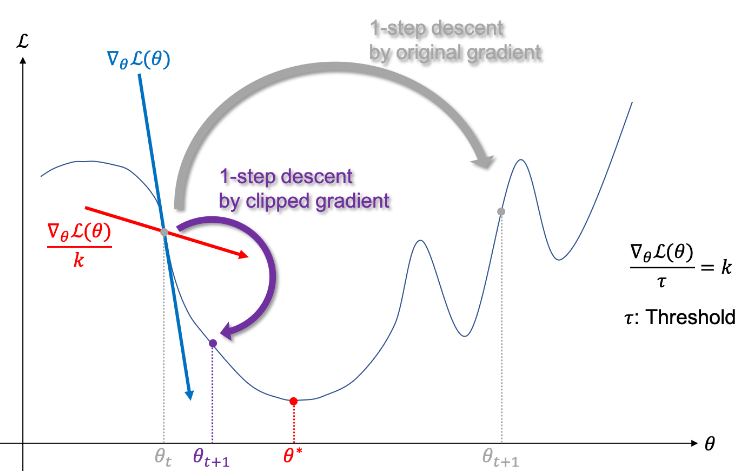

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
  model.train()
  epoch_loss = 0

  for i, batch in enumerate(iterator):
    src = batch.src
    trg = batch.trg

    optimizer.zero_grad()

    output = model(src,trg)
    # output: [출력 단어 개수, 배치 크기, 출력 차원]
    output_dim = output.shape[-1]

    output = output[1:].view(-1,output_dim)
    # output = [(출력 단어의 개수 - 1) * batch size, output dim]
    trg = trg[1:].view(-1)
    # trg = [(타겟 단어의 개수 - 1) * batch size]
    loss = criterion(output, trg)
    loss.backward()
    # 기울기(gradient) clipping 진행
    torch.nn.utils.clip_grad_norm_(model.parameters(),clip)

    optimizer.step()

    epoch_loss += loss.item()

  return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
  model.eval()
  epoch_loss = 0

  with torch.no_grad():
    for i , batch in enumerate(iterator):
      src = batch.src
      trg = batch.trg

      output = model(src,trg,0)
      output_dim = output.shape[-1]

      output = output[1:].view(-1,output_dim)

      trg = trg[1:].view(-1)

      loss = criterion(output,trg)

      epoch_loss += loss.item()

  return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

Perplexity는 언어 모델이 얼마나 정확하게 문장을 생성하는지 판단할 수 있는 성능지표입니다.

Perplexity는 테스트 세트 문장의 발생 확률의 역수를 단어 수로 정규화 하여 계산됩니다.

따라서 Perplexity가 높다는 것은 언어모델이 매 순간 골라야할 가짓수가 많아 혼란스러워 함을 의미합니다.

In [ ]:
import time
import math
import random

N_EPOCHS = 25
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  start_time =  time.time()

  train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
  valid_loss = evaluate(model, valid_iterator, criterion)

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'seq2seq.pt') # 모델 parameter만 저장
  
  print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
  print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 0m 50s
	Train Loss: 5.383 | Train PPL: 217.724
	Validation Loss: 5.157 | Validation PPL: 173.686
Epoch: 02 | Time: 0m 51s
	Train Loss: 5.011 | Train PPL: 150.116
	Validation Loss: 5.020 | Validation PPL: 151.466
Epoch: 03 | Time: 0m 51s
	Train Loss: 4.718 | Train PPL: 111.938
	Validation Loss: 4.975 | Validation PPL: 144.765
Epoch: 04 | Time: 0m 51s
	Train Loss: 4.531 | Train PPL: 92.842
	Validation Loss: 4.844 | Validation PPL: 126.936
Epoch: 05 | Time: 0m 52s
	Train Loss: 4.328 | Train PPL: 75.780
	Validation Loss: 4.726 | Validation PPL: 112.863
Epoch: 06 | Time: 0m 51s
	Train Loss: 4.200 | Train PPL: 66.681
	Validation Loss: 4.689 | Validation PPL: 108.694
Epoch: 07 | Time: 0m 51s
	Train Loss: 4.050 | Train PPL: 57.407
	Validation Loss: 4.519 | Validation PPL: 91.734
Epoch: 08 | Time: 0m 51s
	Train Loss: 3.935 | Train PPL: 51.160
	Validation Loss: 4.419 | Validation PPL: 82.990
Epoch: 09 | Time: 0m 51s
	Train Loss: 3.836 | Train PPL: 46.330
	Validation Loss: 4.370

In [ ]:
# # 학습된 모델 저장
# from google.colab import files

# files.download('seq2seq.pt')

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ERgwTMYWR7FMhApROaNvZREBTjEDi00ttSzt8ZNj1PS_5g?download=1 -O seq2seq.pt

--2022-04-12 08:26:29--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ERgwTMYWR7FMhApROaNvZREBTjEDi00ttSzt8ZNj1PS_5g?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 52.105.209.27
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|52.105.209.27|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/seq2seq.pt?ga=1 [following]
--2022-04-12 08:26:30--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/seq2seq.pt?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 55600205 (53M) [application/octet-stream]
Saving to: ‘seq2seq.pt’

seq2seq.pt          100%[===================>]  53.02M  12.7MB/s    in 4.2s    

2022-04-12 08:26:34 (12.7 MB/s) - ‘seq2seq.pt’ saved [55600205/55600205]



In [ ]:
model.load_state_dict(torch.load('seq2seq.pt'))

RuntimeError: ignored

In [ ]:
# 번역(translation) 함수
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval() # 평가 모드

    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    # print(f"전체 소스 토큰: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    # print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    # 인코더(endocer)에 소스 문장을 넣어 문맥 벡터(context vector) 계산
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        # 이전에 출력한 단어가 현재 단어로 입력될 수 있도록
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:]

In [ ]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')
print("모델 출력 결과:", " ".join(translate_sentence(src, SRC, TRG, model, device)))

소스 문장: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien.']
타겟 문장: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside.']
모델 출력 결과: a mother and groom are a a a a <eos>


In [ ]:
src = tokenize_de("Guten Abend.")

print(f'소스 문장: {src}')
print("모델 출력 결과:", " ".join(translate_sentence(src, SRC, TRG, model, device)))

소스 문장: ['.', 'Abend', 'Guten']
모델 출력 결과: two <unk> <unk> <eos>


### BLEU 적용해보기

In [ ]:
from torchtext.data.metrics import bleu_score

iterator = test_iterator
total_score = 0
model.eval()
with torch.no_grad():
  for idx in range(len(test_dataset.examples)):
    src = vars(test_dataset.examples[idx])['src']
    trg = vars(test_dataset.examples[idx])['trg']
    print(f' trg len : {len(trg)}')
    print(f' trg : {trg}')
    print(f' translate len : {len(translate_sentence(src, SRC, TRG, model, device)[:-1])}')
    print(f' translate text : {translate_sentence(src, SRC, TRG, model, device)[:-1]}')
    score = bleu_score(trg,translate_sentence(src, SRC, TRG, model, device)[:-1],weights = [1,0,0,0])

    total_score += score
    print(total_score)
  print(f' score : {total_score} / ({len(test_dataset)})')


# score = sentence_bleu(reference,candidate,weights = (1,0,0,0))
# score = corpus_bleu(reference, candidate, weights = (1,0,0,0))

# print(score)


 trg len : 9
 trg : ['a', 'man', 'in', 'an', 'orange', 'hat', 'starring', 'at', 'something.']
 translate len : 8
 translate text : ['a', 'man', 'in', 'a', 'white', 'hat', 'is', '<unk>']


AssertionError: ignored